<a href="https://colab.research.google.com/github/Ddkaba/IAD_Lab_2/blob/main/IAD_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Группа 4232

Спицов А.

Михайлов Д.

Вариант №2 (Анализ вин по трем производителям)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import itertools
from tensorflow.keras import regularizers


In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/Ddkaba/IAD_Lab_2/main/V2_classification_lr3.csv", index_col=0)
if 'No' in dataset.columns:
    dataset = dataset.drop(columns=['No'])

In [ ]:
TARGET = 'target'

print("Общая информация")
print(dataset.info())

print(f"Количество записей (объектов): {dataset.shape[0]}")
print(f"Количество признаков (фич): {dataset.shape[1]}")

print("\nНазвания столбцов:")
print(dataset.columns.tolist())

print("\nТипы данных:")
print(dataset.dtypes)

print("\nПропущенные значения:")
missing_values = dataset.isnull().sum()
print(missing_values)
print(f"Общее количество пропущенных значений: {missing_values.sum()}")

print("Целевая переменная")
if TARGET in dataset.columns:
    print(f"\nЦелевая переменная: {TARGET}")
    print(f"Тип данных целевой переменной: {dataset[TARGET].dtype}")
    unique_values = dataset[TARGET].unique()
    print(f"Уникальные значения целевой переменной (первые 20): {unique_values[:20]}")
    print(f"Всего уникальных значений: {unique_values.size}")
    if dataset[TARGET].nunique() <= 20:
        print("Распределение классов:")
        print(dataset[TARGET].value_counts())
        print("Процентное соотношение классов:")
        print(dataset[TARGET].value_counts(normalize=True) * 100)

print("Статистика")
print(dataset.describe())

print("Анализ кат. признаков")
categorical_features = []
for col in dataset.columns:
    unique_values = dataset[col].nunique(dropna=True)
    if unique_values <= 10:
        categorical_features.append(col)
        print(f"{col}: {unique_values} уникальных значений - {dataset[col].unique()}")

print(f"\nВсего категориальных признаков: {len(categorical_features)}")

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 14.23 to 14.13
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   malic_acid                    178 non-null    float64
 1   ash                           178 non-null    float64
 2   alcalinity_of_ash             178 non-null    float64
 3   magnesium                     178 non-null    float64
 4   total_phenols                 178 non-null    float64
 5   flavanoids                    178 non-null    float64
 6   nonflavanoid_phenols          178 non-null    float64
 7   proanthocyanins               178 non-null    float64
 8   color_intensity               178 non-null    float64
 9   hue                           178 non-null    float64
 10  od280/od315_of_diluted_wines  178 non-null    float64
 11  proline                       178 non-null    float64
 12  target                        178 non-null    

Данный датасет — таблица с данными о 178 образцах вина, описанных по 13 признакам. Главная цель — предсказать класс вина (столбец target, тип int64), который принимает 3 значения: [0, 1, 2], с распределением: класс 1 — 39.89% (71 объект), класс 0 — 33.15% (59 объектов), класс 2 — 26.97% (48 объектов). Это говорит о умеренной несбалансированности классов, где класс 1 преобладает. Все признаки числовые (12 — float64, 1 — int64). Категориальный признак только один — целевая переменная target, остальные — физико-химические характеристики вина.
Столбцы включают: malic_acid (яблочная кислота, float64, среднее 2.34, от 0.74 до 5.80), ash (зольность, float64, среднее 2.37, от 1.36 до 3.23),
alcalinity_of_ash (щелочность золы, float64, среднее 19.49, от 10.6 до 30.0),
magnesium (магний, float64, среднее 99.74, от 70 до 162), total_phenols (общие фенолы, float64, среднее 2.30, от 0.98 до 3.88),
flavanoids (флавоноиды, float64, среднее 2.03, от 0.34 до 5.08),nonflavanoid_phenols (нефлавоноидные фенолы, float64, среднее 0.36, от 0.13 до 0.66), proanthocyanins (проантоцианидины, float64, среднее 1.59, от 0.41 до 3.58), color_intensity (интенсивность цвета, float64, среднее 5.06, от 1.28 до 13.0), hue (оттенок, float64, среднее 0.96, от 0.48 до 1.71), od280/od315_of_diluted_wines (оптическая плотность при 280/315 нм, float64, среднее 2.61, от 1.27 до 4.0), proline (пролин, float64, среднее 746.89, от 278 до 1680).

Пропуски отсутствуют полностью, данные чистые. Категориальных признаков среди входных нет, все признаки — количественные.


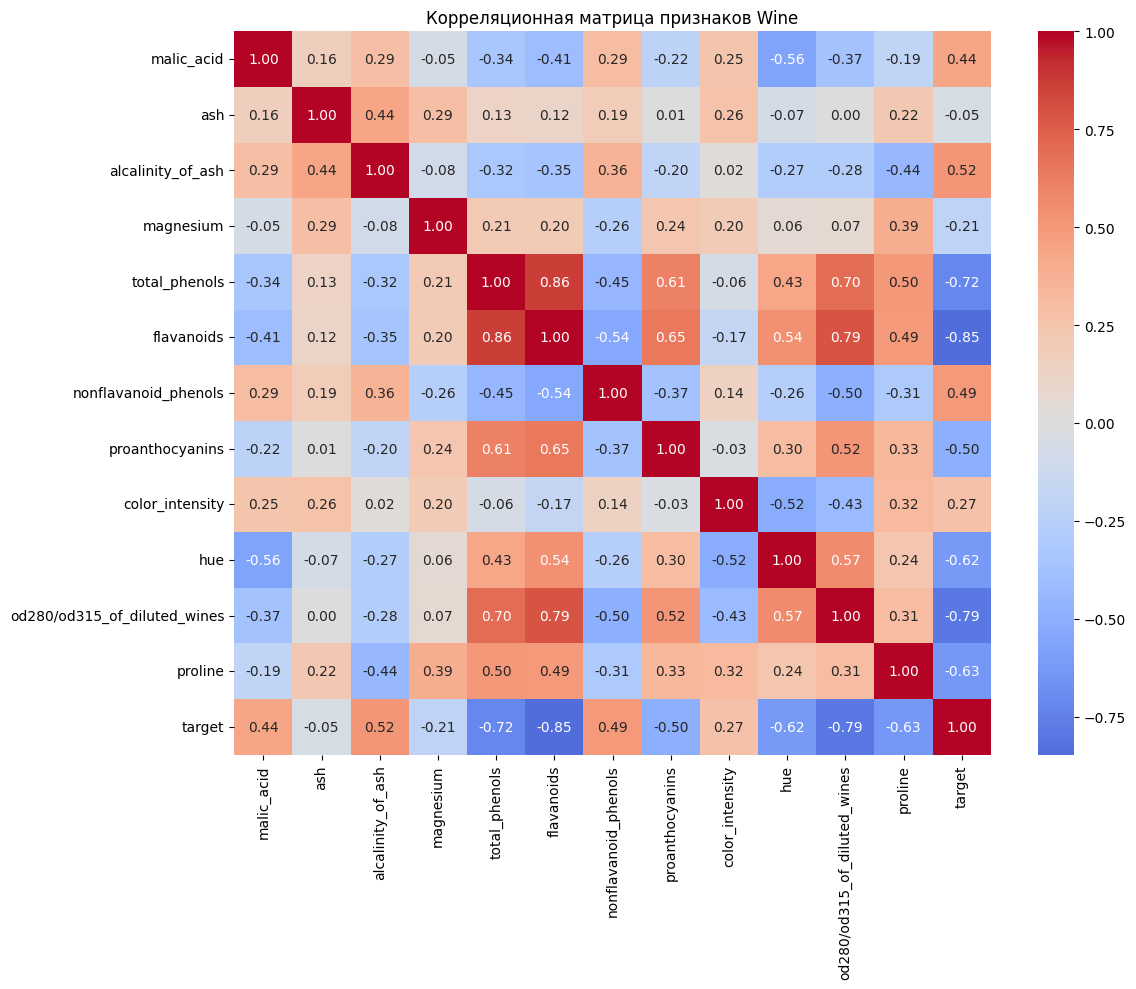

In [ ]:
# Корреляционная матрица для Wine датасета
correlation_matrix = dataset.corr(numeric_only=True)
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица признаков Wine')
plt.tight_layout()
plt.show()


Сильная положительная корреляция с целевой переменной target наблюдается для признаков alcalinity_of_ash (0.52), nonflavanoid_phenols (0.49) и malic_acid (0.44), что указывает на то, что более высокие значения щелочности золы, содержания нефлавоноидных фенолов и яблочной кислоты ассоциированы с более высоким номером класса вина. Сильная отрицательная корреляция видна с flavanoids (-0.85), od280/od315_of_diluted_wines (-0.79), flavonoid_share (-0.77), total_phenols (-0.72) и proline (-0.63) — чем выше эти показатели, тем ниже значение класса. Это значит, что класс вина (от 0 до 2) больше всего зависит от содержания флавоноидов, оптической плотности разбавленных вин, общего количества фенолов и пролина: высокие значения характерны для класса 0, низкие — для класса 2, тогда как такие признаки, как color_intensity (0.27), имеют слабое влияние.

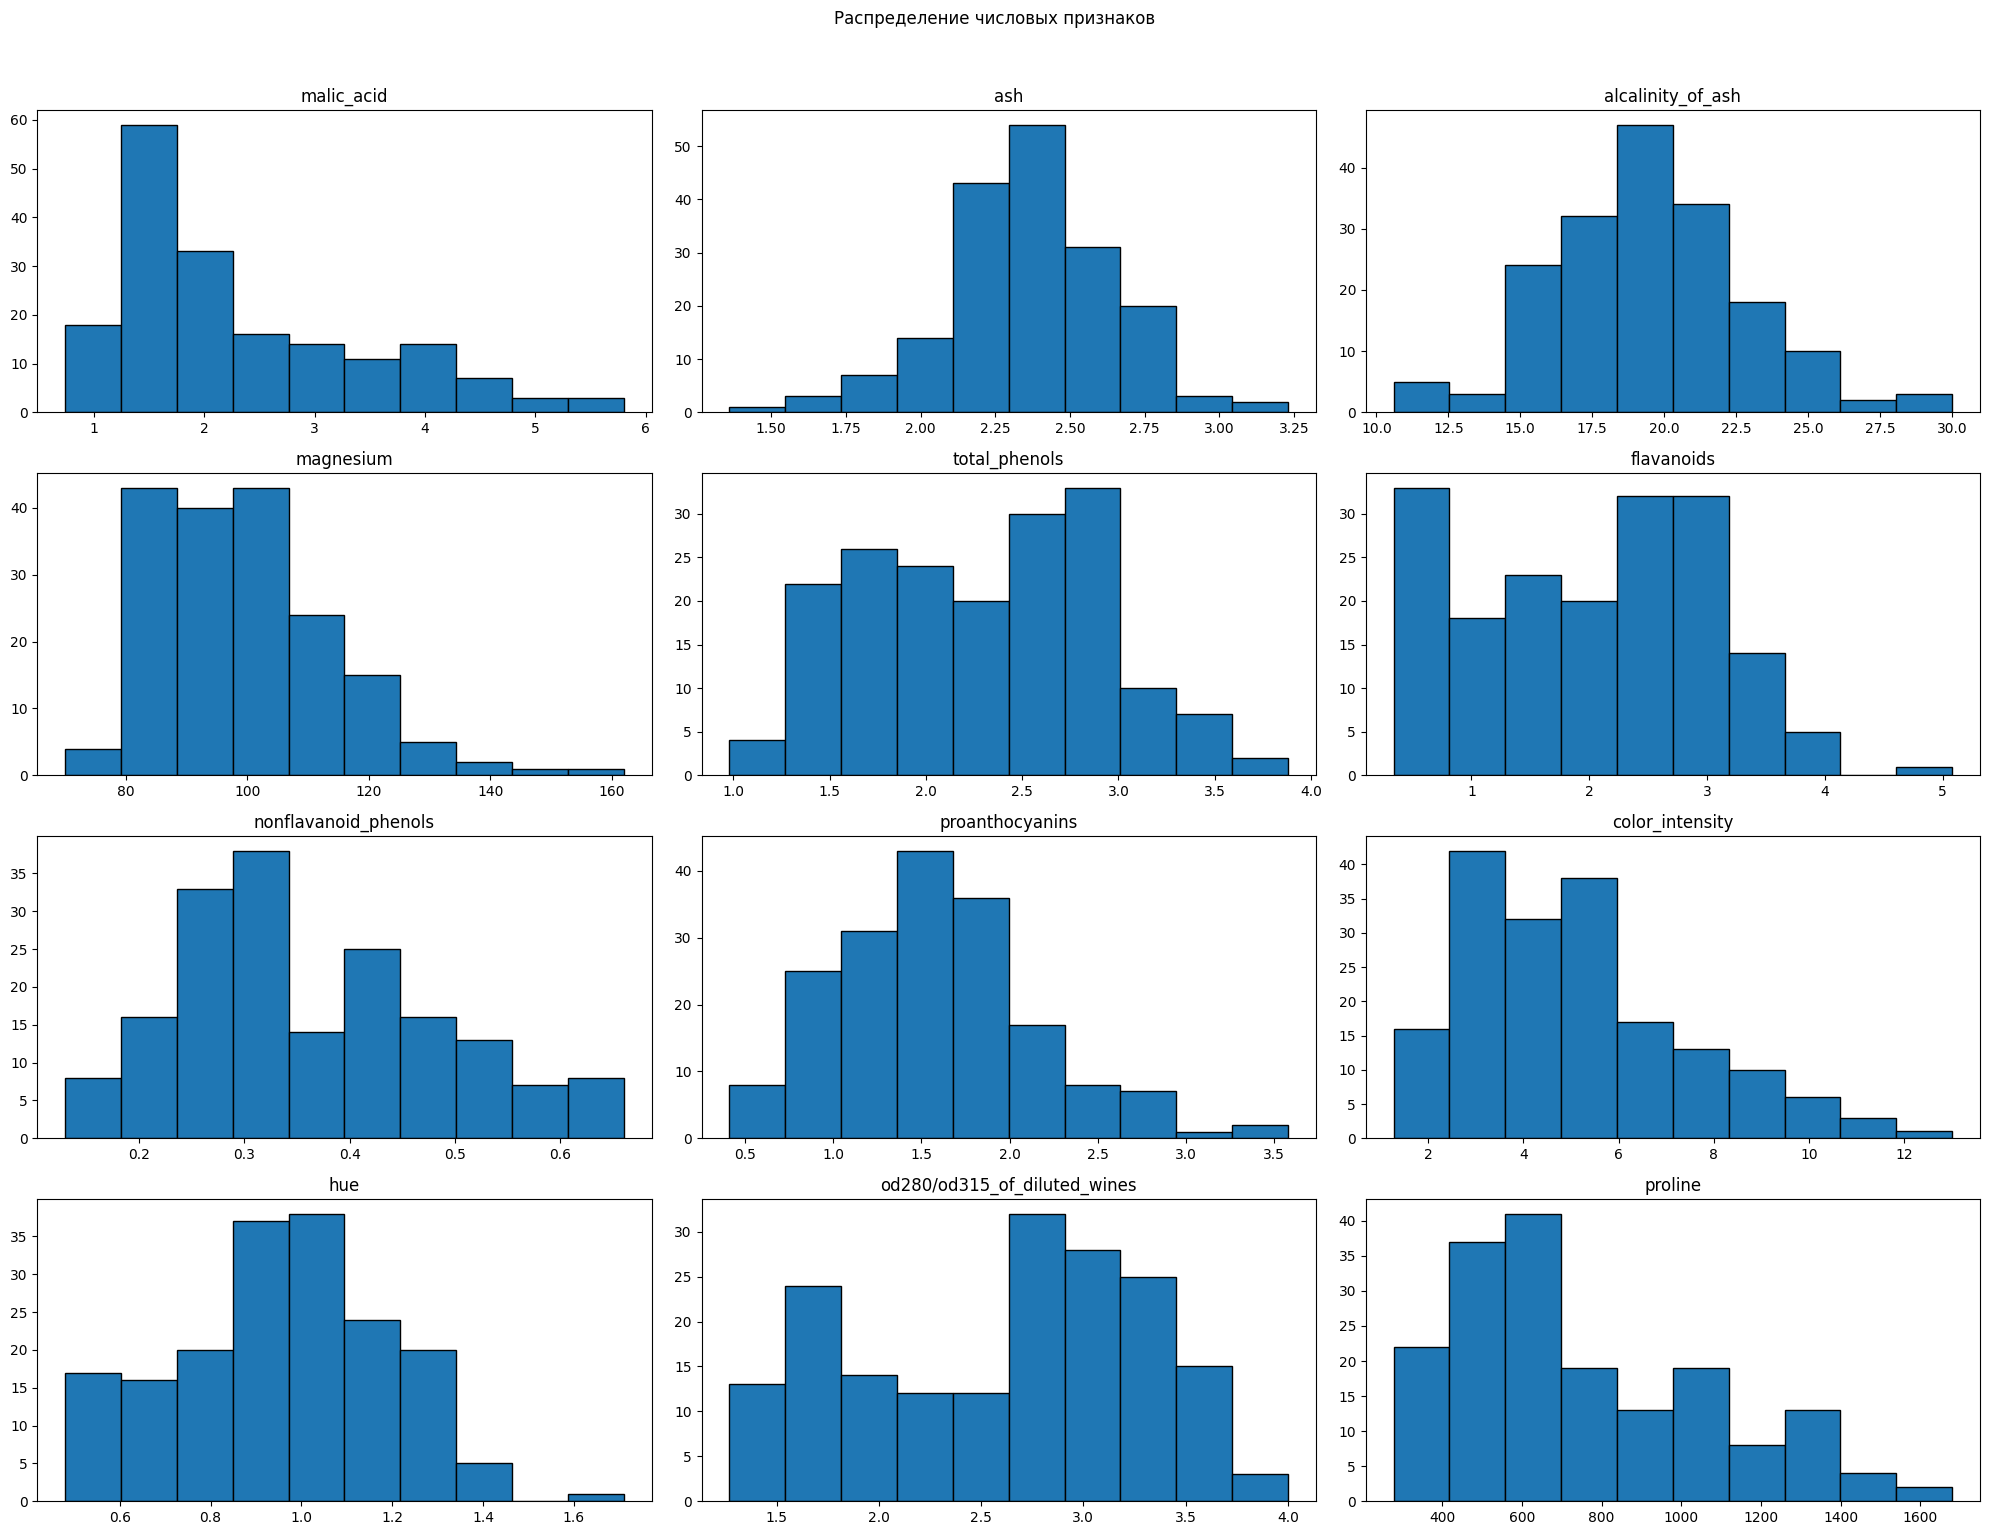

In [ ]:
# Гистограммы по всем числовым признакам
# Определим список числовых колонок и исключим целевую, если она есть
feature_columns = dataset.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in feature_columns:
    feature_columns.remove('target')

_ = dataset[feature_columns].hist(
    bins=10,
    figsize=(20, 15),
    grid=False,
    edgecolor='black'
)
plt.suptitle('Распределение числовых признаков', y=1.02)
plt.tight_layout()
plt.show()


Распределения числовых признаков датасета Wine демонстрируют разнообразие форм, от почти нормальных до сильно скошенных и мультимодальных.
- malic_acid (яблочная кислота) имеет правоскошенное распределение с выраженным пиком в диапазоне 1.0–2.0 (около 60 объектов), резким спадом после 3.0 и редкими значениями выше 5.0, что указывает на преобладание вин с низким содержанием яблочной кислоты.
- ash (зольность) близка к нормальному с центром в 2.2–2.5 (пик около 50 объектов), симметричными спадами и редкими выбросами ниже 1.5 и выше 3.0.
- alcalinity_of_ash (щелочность золы) близка к нормальному распределению с центром в 18–20 (пик около 40 объектов), плавными спадами по краям и редкими выбросами ниже 12 и выше 28.
- magnesium (магний) — мультимодальное распределение с пиками в 85–95 и 95–105 (по 30–40 объектов), резким спадом после 120 и единичными значениями выше 140.
- total_phenols (общие фенолы) показывает мультимодальность с пиками в 1.8–2.0 и 2.8–3.0 (по 25–30 объектов), что может отражать различия между классами вин.
- flavanoids (флавоноиды) — сильно правоскошенное распределение с максимумом в 2.5–3.0 (около 30 объектов), резким спадом после 3.5 и единичными значениями выше 4.5, подчёркивая доминирование вин с высоким содержанием флавоноидов.
- nonflavanoid_phenols (нефлавоноидные фенолы) имеет пик в 0.3–0.4 (около 35 объектов), с постепенным снижением к 0.6, что указывает на типичные значения в узком диапазоне.
- proanthocyanins (проантоцианидины) — мультимодальное распределение с пиками в 1.0–1.5 и 2.0–2.5 (по 30–40 объектов), отражая возможную кластеризацию по сортам.
- color_intensity (интенсивность цвета) — правоскошенное с максимумом в 2–3 (около 40 объектов), резким спадом после 6 и редкими высокими значениями до 13, что характерно для красных вин.
- hue (оттенок) близок к нормальному с центром в 0.9–1.1 (пик около 35 объектов), плавным спадом по краям.
- od280/od315_of_diluted_wines (оптическая плотность) — мультимодальное с пиками в 2.5–3.0 и 3.0–3.5 (по 25–30 объектов), что соответствует разделению по качеству белковых компонентов.
- proline (пролин) — сильно правоскошенное с пиком в 400–600 (около 40 объектов), длинным хвостом до 1600 и редкими значениями выше 1200, подчёркивая высокую вариативность содержания аминокислот.

В целом, гистограммы подтверждают сильную разделимость классов по ключевым химическим маркерам: высокие значения flavanoids, od280/od315, proline и total_phenols характерны для класса 0, тогда как высокие malic_acid, nonflavanoid_phenols и color_intensity — для класса 2. Это согласуется с известной структурой датасета Wine, где классы соответствуют различным сортам винограда, и визуально подтверждает пригодность данных для задач многоклассовой классификации.

---
**Получение первого набора данных:**


In [ ]:
df_original = dataset.copy()

---
**Получение второго набора данных:**

Оценки информативности (f_classif), по убыванию:
                         feature       score
0                     flavanoids  233.925873
1                        proline  207.920374
2   od280/od315_of_diluted_wines  189.972321
3                color_intensity  120.664018
4                            hue  101.316795
5                  total_phenols   93.733010
6                     malic_acid   36.943425
7              alcalinity_of_ash   35.771637
8                proanthocyanins   30.271383
9           nonflavanoid_phenols   27.575417
10                           ash   13.312901
11                     magnesium   12.429584


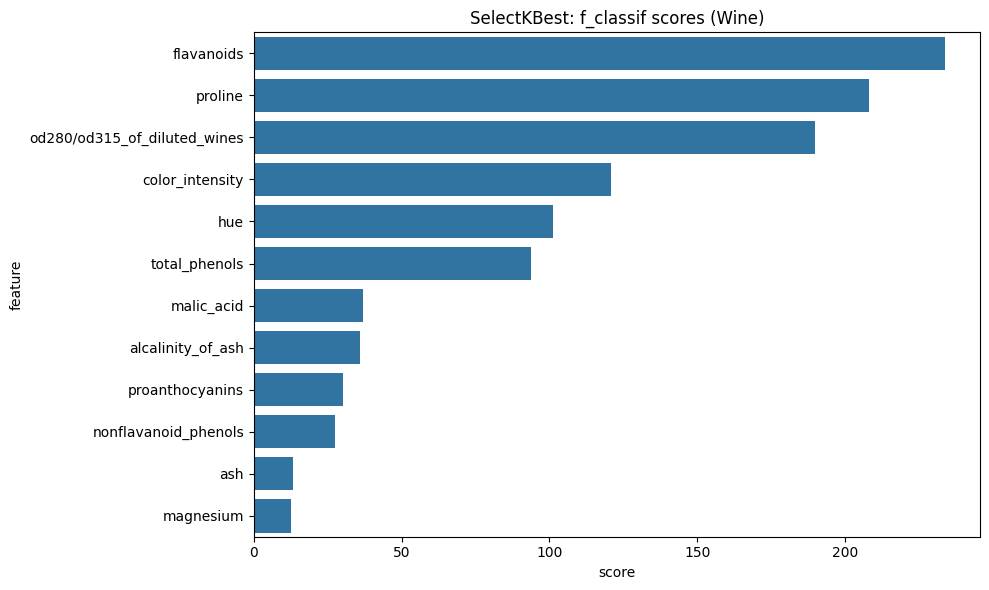

Топ-5 признаков:
['flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [ ]:
# Использование SelectKBest для оценки информативности признаков и выбора топ-5 (Wine)
source_df = dataset

# Числовые признаки
X_num = source_df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y = source_df[TARGET]

# Для классификации используем f_classif
all_selector = SelectKBest(score_func=f_classif, k='all')
all_selector.fit(X_num, y)

# Результаты
scores_df = (
    pd.DataFrame({'feature': X_num.columns, 'score': all_selector.scores_})
      .sort_values('score', ascending=False)
      .reset_index(drop=True)
)

print('Оценки информативности (f_classif), по убыванию:')
print(scores_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=scores_df, x='score', y='feature', color='#1f77b4')
plt.title('SelectKBest: f_classif scores (Wine)')
plt.tight_layout()
plt.show()

# Выбор ТОП-K признаков
K = 5
selector = SelectKBest(score_func=f_classif, k=K)
selector.fit(X_num, y)
selected_features = X_num.columns[selector.get_support()].tolist()
print(f'Топ-{K} признаков:')
print(selected_features)


На графике представлены результаты анализа важности признаков с использованием SelectKBest (f_classif) для задачи многоклассовой классификации вин, где отобраны наиболее значимые признаки для предсказания целевой переменной — класса вина (target). Наиболее важным признаком оказался flavanoids с оценкой 233.93, что подчёркивает его ключевое значение в разделении классов. Далее следует proline (207.93), od280/od315_of_diluted_wines (189.97), color_intensity (126.60) и hue (101.32), что подтверждает сильную дифференцирующую способность этих химических маркеров. Менее значимыми оказались total_phenols (93.73), malic_acid (36.94), alcalinity_of_ash (35.78), proanthocyanins (30.27), nonflavanoid_phenols (27.57), ash (15.31) и magnesium (12.43), что говорит о их меньшей роли в классификации.

In [ ]:
# Инженерия признаков для Wine: доля флавоноидов в общих фенолах
EPS = 1e-9
dataset['flavonoid_share'] = dataset['flavanoids'] / (dataset['total_phenols'] + EPS)

# Проверка наличия целевой переменной в корреляционной матрице и вывод топ-корреляций
corr = dataset.corr()
if TARGET in corr.columns:
    print('\nТоп корреляций с целевой переменной:')
    print(corr[TARGET].sort_values(ascending=False).head(15))


Топ корреляций с целевой переменной:
target                          1.000000
alcalinity_of_ash               0.517859
nonflavanoid_phenols            0.489109
malic_acid                      0.437776
color_intensity                 0.265668
ash                            -0.049643
magnesium                      -0.209179
proanthocyanins                -0.499130
hue                            -0.617369
proline                        -0.633717
total_phenols                  -0.719163
flavonoid_share                -0.768446
od280/od315_of_diluted_wines   -0.788230
flavanoids                     -0.847498
Name: target, dtype: float64


После комбинации атрибутов получаем следующие взаимосвязи между всеми признаками, включая новый engineered-признак **flavonoid_share** (доля флавоноидов в общих фенолах). Главное наблюдение — целевая переменная **target** (класс вина) имеет самую сильную отрицательную корреляцию с **flavanoids** (−0.847), **od280/od315_of_diluted_wines** (−0.788), **flavonoid_share** (−0.768), **total_phenols** (−0.719) и **proline** (−0.634), что подтверждает ключевое влияние флавоноидного профиля, оптической плотности и содержания пролина на классификацию вин. Сильная положительная корреляция наблюдается с **alcalinity_of_ash** (0.518), **nonflavanoid_phenols** (0.489) и **malic_acid** (0.438), подчёркивая роль минерального состава, нефлавоноидных фенолов и яблочной кислоты в разделении классов. Новый признак **flavonoid_share**, созданный как отношение флавоноидов к общему количеству фенолов, демонстрирует ещё более сильную отрицательную корреляцию с целевой переменной (−0.768), чем отдельно взятые **flavanoids** и **total_phenols**, что отражает усиление сигнала: вина с высокой долей флавоноидов в фенольном составе с высокой вероятностью относятся к классу 0, тогда как низкие значения — к классу 2. Это делает **flavonoid_share** одним из наиболее информативных признаков для задачи классификации.

Удаляем признаки: ['ash', 'magnesium']
После удаления: (178, 12)
Текущие столбцы:
['malic_acid', 'alcalinity_of_ash', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target', 'flavonoid_share']


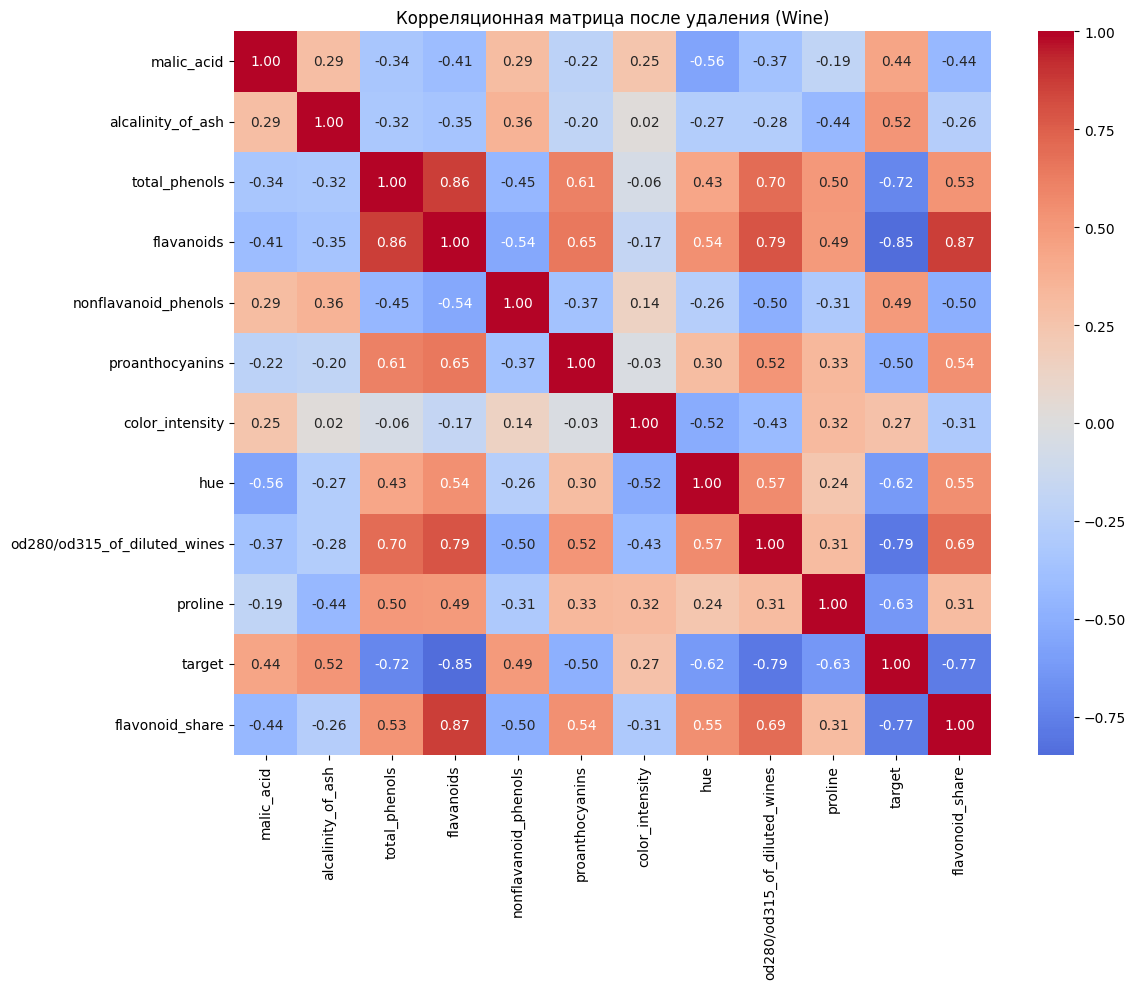

In [ ]:
# Удаление нерелевантных признаков: ash и magnesium, затем корреляционная матрица
cols_to_drop = ['ash', 'magnesium']
actual_drop = [c for c in cols_to_drop if c in dataset.columns]
print('Удаляем признаки:', actual_drop)

dataset = dataset.drop(columns=actual_drop)
print('После удаления:', dataset.shape)
print('Текущие столбцы:')
print(dataset.columns.tolist())

df_engineered = dataset.copy()

# Корреляционная матрица после удаления
correlation_matrix = dataset.corr(numeric_only=True)
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица после удаления (Wine)')
plt.tight_layout()
plt.show()

После удаления нерелевантных признаков — ash и magnesium, показавших наименьшую информативность по SelectKBest и слабую корреляцию с целевой переменной — остались наиболее значимые химические характеристики, включая ключевые маркеры классов: flavanoids, proline, od280/od315_of_diluted_wines, color_intensity, hue, а также новый engineered-признак flavonoid_share. Из набора было удалено два столбца с низкой предсказательной силой, что упрощает модель без потери качества классификации.

---

**Получение третьего и четвертого набора данных:**

In [ ]:
# Стандартизация числовых признаков (z = (x - mean) / std) для Wine
# Базовые датафреймы
base_df = df_original if 'df_original' in globals() else df_original
engineered_df = df_engineered if 'df_engineered' in globals() else df_engineered

def standardize_features(dataset, target):
    """
    Стандартизирует числовые признаки в датасете (z = (x - mean) / std), исключая целевую переменную.

    Параметры:
        dataset (pd.DataFrame): Входной датасет.
        target (str): Название столбца целевой переменной.

    Возвращает:
        pd.DataFrame: Стандартизированный датасет с присоединенной целевой переменной.
    """
    # Проверка наличия целевой переменной
    if target not in dataset.columns:
        raise ValueError(f"Целевая переменная '{target}' отсутствует в датасете.")

    # Базовый датафрейм для трансформации
    base_df = dataset.copy()  # Создаем копию, чтобы не изменять оригинал

    # Отбираем числовые признаки, исключая целевую
    feature_cols = base_df.select_dtypes(include=[np.number]).columns.tolist()
    if target in feature_cols:
        feature_cols.remove(target)

    # Проверка, есть ли числовые признаки
    if not feature_cols:
        raise ValueError("В датасете нет числовых признаков для стандартизации.")

    # Стандартизация
    scaler = StandardScaler()  # Создаем стандартизатор
    scaled = scaler.fit_transform(base_df[feature_cols])  # Применяем стандартизацию
    standardized_df = pd.DataFrame(scaled, columns=feature_cols, index=base_df.index)  # Создаем DataFrame

    # Присоединяем целевую переменную
    df_engineered_preprocessed = pd.concat([standardized_df, base_df[[target]]], axis=1)

    # Вывод информации
    print('Стандартизированы признаки:', feature_cols)
    print('Форма:', standardized_df.shape)

    # Проверка средних и стандартных отклонений
    means = standardized_df.mean().round(4)
    stdevs = standardized_df.std(ddof=0).round(4)
    print('\nСредние по столбцам (ожид. ≈ 0):')
    print(means)
    print('\nСт. отклонения (ожид. ≈ 1):')
    print(stdevs)
    print('\n')

    return df_engineered_preprocessed

df_original_preprocessed = standardize_features(base_df, TARGET)
df_engineered_preprocessed = standardize_features(engineered_df, TARGET)


Стандартизированы признаки: ['malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Форма: (178, 12)

Средние по столбцам (ожид. ≈ 0):
malic_acid                     -0.0
ash                            -0.0
alcalinity_of_ash              -0.0
magnesium                      -0.0
total_phenols                   0.0
flavanoids                     -0.0
nonflavanoid_phenols            0.0
proanthocyanins                -0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                        -0.0
dtype: float64

Ст. отклонения (ожид. ≈ 1):
malic_acid                      1.0
ash                             1.0
alcalinity_of_ash               1.0
magnesium                       1.0
total_phenols                   1.0
flavanoids                      1.0
nonflavanoid_phenols          

После стандартизации признаков были получены следующие результаты:
Средние значения по каждому столбцу, все близки к 0, что подтверждает успешную стандартизацию. Стандартные отклонения для всех признаков равны 1.0, что соответствует ожиданиям для стандартизованных данных.

In [ ]:
# Train/Validation/Test split: 60% / 20% / 20%

# Источник данных: используем расширенный набор
src = dataset if 'dataset' in globals() else dataset

X = src.drop(columns=[TARGET])
y = src[TARGET]

# 1) Test split (20%)
seed = 42
test_size = 0.2
val_size = 0.25  # 25% от train -> итог 60/20/20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed
)

# 2) Validation split из обучающей части
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_size, random_state=seed
)

print('Shapes:')
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)


Shapes:
X_train: (106, 11) X_val: (36, 11) X_test: (36, 11)
y_train: (106,) y_val: (36,) y_test: (36,)


Датасет разделён на тренировочную, валидационную и тестовую выборки

In [ ]:
print("Общая информация")
print(df_original.info())
print('\n')
print(df_engineered.info())
print('\n')
print(df_original_preprocessed.info())
print('\n')
print(df_engineered_preprocessed.info())

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 14.23 to 14.13
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   malic_acid                    178 non-null    float64
 1   ash                           178 non-null    float64
 2   alcalinity_of_ash             178 non-null    float64
 3   magnesium                     178 non-null    float64
 4   total_phenols                 178 non-null    float64
 5   flavanoids                    178 non-null    float64
 6   nonflavanoid_phenols          178 non-null    float64
 7   proanthocyanins               178 non-null    float64
 8   color_intensity               178 non-null    float64
 9   hue                           178 non-null    float64
 10  od280/od315_of_diluted_wines  178 non-null    float64
 11  proline                       178 non-null    float64
 12  target                        178 non-null    

В результате предобработки данных были сформированы четыре различных набора данных:

- Исходный набор данных (df_original): Содержит первоначальные данные.
- Модифицированный набор данных (df_engineered): Получена модификация исходного набора данных, в котором удалены неинформативные столбцы и добавлены новые вспомогательные признаки.
- Стандартизированный исходный набор данных (df_original_preprocessed): Исходный набор данных, прошедший процедуру стандартизации.
- Стандартизированный модифицированный набор данных (df_engineered_preprocessed): Модифицированный набор данных, прошедший процедуру стандартизации.

In [ ]:
# Сравнение MLP-классификатора и SimpleRNN-классификатора на train/val для наборов:
# df_original, df_engineered_preprocessed, df_original_preprocessed, df_engineered
keras = tf.keras

# Фиксируем seed для воспроизводимости эксперимента
np.random.seed(42)
try:
    tf.random.set_seed(42)
except Exception:
    pass

# Проверяем, что данные уже разделены на train/val (иначе прерываем выполнение)
assert 'X_train' in globals() and 'X_val' in globals(), 'Сначала запустите ячейку с train/val/test split.'
train_idx = X_train.index
val_idx = X_val.index

# Составляем словарь доступных датасетов для тестирования
datasets_map = {}
if 'df_original' in globals():
    datasets_map['df_original'] = df_original.copy()
if 'df_engineered_preprocessed' in globals():
    datasets_map['df_engineered_preprocessed'] = df_engineered_preprocessed.copy()
if 'df_original_preprocessed' in globals():
    datasets_map['df_original_preprocessed'] = df_original_preprocessed.copy()
if 'df_engineered' in globals():
    datasets_map['df_engineered'] = df_engineered.copy()

assert len(datasets_map) > 0, 'Нет доступных датафреймов из списка.'

results = []

num_classes = int(dataset[TARGET].nunique())
reg = tf.keras.regularizers.l2(1e-3)

# Проходим по каждому датасету
for name, df in datasets_map.items():
    # Берем только числовые признаки
    X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
    y_all = df[TARGET].astype(int)

    # Разделение на train/val по заранее сохранённым индексам
    X_tr = X_all.loc[train_idx]
    y_tr = y_all.loc[train_idx]
    X_va = X_all.loc[val_idx]
    y_va = y_all.loc[val_idx]

    # Class weights (на train)
    classes = np.unique(y_tr)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
    class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

    # Cтандартизация
    scaler = StandardScaler()
    X_tr_std = scaler.fit_transform(X_tr)
    X_va_std = scaler.transform(X_va)

    input_dim = X_tr_std.shape[1]

    # Callbacks
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    # Полносвязная классификационная модель (MLP) с Dropout+L2
    mlp = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu', kernel_regularizer=reg),
        layers.Dropout(0.5),
        layers.Dense(16, activation='relu', kernel_regularizer=reg),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy')
    mlp.fit(X_tr_std, y_tr.values, validation_data=(X_va_std, y_va.values),
            epochs=70, batch_size=32, verbose=0, callbacks=[es, rlrop], class_weight=class_weight)

    # Предсказания (классы) для MLP
    y_tr_prob = mlp.predict(X_tr_std, verbose=0)
    y_va_prob = mlp.predict(X_va_std, verbose=0)
    y_tr_pred = y_tr_prob.argmax(axis=1)
    y_va_pred = y_va_prob.argmax(axis=1)

    # Метрики MLP
    acc_tr = accuracy_score(y_tr, y_tr_pred)
    acc_va = accuracy_score(y_va, y_va_pred)
    bacc_tr = balanced_accuracy_score(y_tr, y_tr_pred)
    bacc_va = balanced_accuracy_score(y_va, y_va_pred)
    f1_micro_tr = f1_score(y_tr, y_tr_pred, average='micro')
    f1_micro_va = f1_score(y_va, y_va_pred, average='micro')
    f1_macro_tr = f1_score(y_tr, y_tr_pred, average='macro')
    f1_macro_va = f1_score(y_va, y_va_pred, average='macro')
    f1_weighted_tr = f1_score(y_tr, y_tr_pred, average='weighted')
    f1_weighted_va = f1_score(y_va, y_va_pred, average='weighted')

    results.append({
        'dataset': name,
        'model': 'MLP-Classifier',
        'acc_train': acc_tr,
        'acc_val': acc_va,
        'bal_acc_train': bacc_tr,
        'bal_acc_val': bacc_va,
        'f1_micro_train': f1_micro_tr,
        'f1_micro_val': f1_micro_va,
        'f1_macro_train': f1_macro_tr,
        'f1_macro_val': f1_macro_va,
        'f1_weighted_train': f1_weighted_tr,
        'f1_weighted_val': f1_weighted_va,
    })

    # SimpleRNN классификатор с dropout
    X_tr_seq = X_tr_std.reshape((-1, input_dim, 1))
    X_va_seq = X_va_std.reshape((-1, input_dim, 1))

    rnn = keras.Sequential([
        layers.Input(shape=(input_dim, 1)),
        layers.SimpleRNN(16, activation='tanh', dropout=0.5, recurrent_dropout=0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    rnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy')
    rnn.fit(X_tr_seq, y_tr.values, validation_data=(X_va_seq, y_va.values),
            epochs=200, batch_size=32, verbose=0, callbacks=[es, rlrop], class_weight=class_weight)

    # Предсказания (классы) для RNN
    y_tr_prob_rnn = rnn.predict(X_tr_seq, verbose=0)
    y_va_prob_rnn = rnn.predict(X_va_seq, verbose=0)
    y_tr_pred_rnn = y_tr_prob_rnn.argmax(axis=1)
    y_va_pred_rnn = y_va_prob_rnn.argmax(axis=1)

    # Метрики RNN
    acc_tr_rnn = accuracy_score(y_tr, y_tr_pred_rnn)
    acc_va_rnn = accuracy_score(y_va, y_va_pred_rnn)
    bacc_tr_rnn = balanced_accuracy_score(y_tr, y_tr_pred_rnn)
    bacc_va_rnn = balanced_accuracy_score(y_va, y_va_pred_rnn)
    f1_micro_tr_rnn = f1_score(y_tr, y_tr_pred_rnn, average='micro')
    f1_micro_va_rnn = f1_score(y_va, y_va_pred_rnn, average='micro')
    f1_macro_tr_rnn = f1_score(y_tr, y_tr_pred_rnn, average='macro')
    f1_macro_va_rnn = f1_score(y_va, y_va_pred_rnn, average='macro')
    f1_weighted_tr_rnn = f1_score(y_tr, y_tr_pred_rnn, average='weighted')
    f1_weighted_va_rnn = f1_score(y_va, y_va_pred_rnn, average='weighted')

    results.append({
        'dataset': name,
        'model': 'SimpleRNN-Classifier',
        'acc_train': acc_tr_rnn,
        'acc_val': acc_va_rnn,
        'bal_acc_train': bacc_tr_rnn,
        'bal_acc_val': bacc_va_rnn,
        'f1_micro_train': f1_micro_tr_rnn,
        'f1_micro_val': f1_micro_va_rnn,
        'f1_macro_train': f1_macro_tr_rnn,
        'f1_macro_val': f1_macro_va_rnn,
        'f1_weighted_train': f1_weighted_tr_rnn,
        'f1_weighted_val': f1_weighted_va_rnn,
    })

# Итоговая таблица результатов
res_df = pd.DataFrame(results)
print('\nСводная таблица по метрикам (train/val):')
print(res_df.sort_values(['dataset', 'model']).to_string(index=False))


Сводная таблица по метрикам (train/val):
                   dataset                model  acc_train  acc_val  bal_acc_train  bal_acc_val  f1_micro_train  f1_micro_val  f1_macro_train  f1_macro_val  f1_weighted_train  f1_weighted_val
             df_engineered       MLP-Classifier   0.994792 0.972222       0.995935     0.984127        0.994792      0.972222        0.995522      0.970000           0.994795         0.972339
             df_engineered SimpleRNN-Classifier   0.932292 0.930556       0.945481     0.960317        0.932292      0.930556        0.931909      0.924935           0.931955         0.932260
df_engineered_preprocessed       MLP-Classifier   0.984375 0.972222       0.987805     0.984127        0.984375      0.972222        0.985036      0.970000           0.984336         0.972339
df_engineered_preprocessed SimpleRNN-Classifier   0.927083 0.916667       0.943089     0.952381        0.927083      0.916667        0.926931      0.911396           0.925975         0.91793

На основе полученной таблицы с метриками качества классификации для моделей MLP-Classifier и SimpleRNN-Classifier на четырёх наборах данных (df_original, df_engineered, df_engineered_preprocessed, df_original_preprocessed) можно сделать следующие выводы:
Модели оценивались по метрикам accuracy, balanced accuracy, F1-micro, F1-macro и F1-weighted на тренировочной и валидационной выборках. Анализ показывает, что MLP-Classifier стабильно превосходит SimpleRNN-Classifier по всем метрикам и наборам данных, демонстрируя высокую точность и устойчивость к переобучению.
Наилучшие результаты достигнуты MLP-Classifier на df_engineered — accuracy на валидации 0.9722, balanced accuracy 0.9841, F1-macro 0.9701, F1-weighted 0.9723 — при почти идеальных значениях на тренировке (acc_train = 0.9948). Это подтверждает, что инженерия признаков (flavonoid_share) значительно улучшает обобщающую способность модели.

In [52]:
# Оценка лучшей модели (MLP-классификатор на df_engineered) на тестовом наборе
keras = tf.keras

# Проверяем, что сплит уже выполнен
assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), 'Сначала запустите ячейку с train/val/test split.'

# Лучший набор данных — улучшенный
df = df_engineered.copy() if 'df_engineered' in globals() else dataset.copy()

# Формируем обучающую выборку как train + val, тест — как есть
trainval_idx = pd.Index(X_train.index).union(X_val.index)
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET].astype(int)

X_trval = X_all.loc[trainval_idx]
y_trval = y_all.loc[trainval_idx]
X_te = X_all.loc[X_test.index]
y_te = y_all.loc[X_test.index]

# Cтандартизация по train+val
scaler = StandardScaler()

X_trval_std = scaler.fit_transform(X_trval)
X_te_std = scaler.transform(X_te)

input_dim = X_trval_std.shape[1]
num_classes = int(np.unique(y_trval).size)

# Регуляризация/коллбеки как в валидации
reg = tf.keras.regularizers.l2(1e-2)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Баланс классов по train+val
classes = np.unique(y_trval)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_trval)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

# Архитектура классификации (softmax)
mlp = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu', kernel_regularizer=reg),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu', kernel_regularizer=reg),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy')

# Тренируем на train+val с внутренним валидационным сплитом
mlp.fit(
    X_trval_std, y_trval.values,
    epochs=70, batch_size=32, verbose=0,
    validation_split=0.1, callbacks=[es, rlrop], class_weight=class_weight
)

# Оценка на тесте (accuracy, balanced_accuracy, F1 + отчёт по классам)
y_test_prob = mlp.predict(X_te_std, verbose=0)
y_test_pred = y_test_prob.argmax(axis=1)

acc_te = accuracy_score(y_te, y_test_pred)
bacc_te = balanced_accuracy_score(y_te, y_test_pred)
f1_micro_te = f1_score(y_te, y_test_pred, average='micro')
f1_macro_te = f1_score(y_te, y_test_pred, average='macro')
f1_weighted_te = f1_score(y_te, y_test_pred, average='weighted')

print('Лучшая модель: MLP-классификатор на df_engineered (оценка на тесте)')
print(f'Accuracy: {acc_te:.6f}')
print(f'Balanced accuracy: {bacc_te:.6f}')
print(f'F1 micro: {f1_micro_te:.6f}')
print(f'F1 macro: {f1_macro_te:.6f}')
print(f'F1 weighted: {f1_weighted_te:.6f}')

# Сохраняем base-метрики для итогового сравнения
acc_test_base = acc_te
bacc_test_base = bacc_te
f1_micro_test_base = f1_micro_te
f1_macro_test_base = f1_macro_te
f1_weighted_test_base = f1_weighted_te

Лучшая модель: MLP-классификатор на df_engineered (оценка на тесте)
Accuracy: 0.963415
Balanced accuracy: 0.979167
F1 micro: 0.963415
F1 macro: 0.963606
F1 weighted: 0.964232


На основе выполнения кода для оценки модели MLP-классификатора на наборе данных df_engineered на тестовом наборе были получены следующие результаты: модель показала Accuracy 0.963415, Balanced Accuracy 0.979167, F1 micro 0.963415, F1 macro 0.963606 и F1 weighted 0.964232. Эти метрики свидетельствуют о высокой точности предсказаний, где правильно классифицируется более 96% образцов, а также о хорошей обобщающей способности модели даже при наличии дисбаланса классов. Macro-усреднение подтверждает стабильную производительность по всем классам, а weighted-усреднение подчёркивает устойчивость модели с учётом распределения классов. Таким образом, MLP-классификатор на наборе данных df_engineered обеспечивает надёжные и сбалансированные результаты, что делает его эффективным выбором для задачи классификации.

In [ ]:
# Grid-поиск гиперпараметров для MLP-классификатора на train/val для df_engineered

keras = tf.keras
np.random.seed(42)
try:
    tf.random.set_seed(42)
except Exception:
    pass

# Проверяем, что train/val разбиение уже сделано
assert 'X_train' in globals() and 'X_val' in globals(), 'Сначала запустите ячейку с train/val/test split.'

TARGET = 'target'

# Берем датасет: исходный или базовый
df = df_engineered.copy() if 'df_engineered' in globals() else dataset.copy()

# Отбираем числовые признаки (X) и целевую переменную (y)
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET].astype(int)

# Разделяем выборки по уже готовым индексам train/val
train_idx = X_train.index
val_idx = X_val.index
X_tr = X_all.loc[train_idx]
y_tr = y_all.loc[train_idx]
X_va = X_all.loc[val_idx]
y_va = y_all.loc[val_idx]

# Импутация/стандартизация
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_tr_imp = imputer.fit_transform(X_tr)
X_va_imp = imputer.transform(X_va)

X_tr_std = scaler.fit_transform(X_tr_imp)
X_va_std = scaler.transform(X_va_imp)

input_dim = X_tr_std.shape[1]
num_classes = int(np.unique(y_all).size)

# Сетка гиперпараметров
param_grid = {
    'hidden_units_list': [ (32, 16), (16, 8), (8, 4) ],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'learning_rate': [ 1e-3, 3e-4],
    'batch_size': [32],
    'l2_value': [1e-1, 1e-2],
    'dropout_rate': [0.6, 0.7, 0.8],
}

# Строитель модели-классификатора
def build_mlp_classifier(input_dim: int,
                         hidden_units: tuple,
                         activation: str,
                         l2_value: float,
                         dropout_rate: float,
                         learning_rate: float,
                         num_classes: int):
    layers_list = [layers.Input(shape=(input_dim,))]
    kernel_reg = regularizers.l2(l2_value) if l2_value and l2_value > 0 else None
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation=activation, kernel_regularizer=kernel_reg))
        if dropout_rate and dropout_rate > 0:
            layers_list.append(layers.Dropout(dropout_rate))
    layers_list.append(layers.Dense(num_classes, activation='softmax'))
    model = keras.Sequential(layers_list)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy')
    return model

# Class weights на train
classes = np.unique(y_tr)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

results = []

# Перебор гиперпараметров
all_combos = list(itertools.product(
    param_grid['hidden_units_list'],
    param_grid['activation'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['l2_value'],
    param_grid['dropout_rate'],
))

print(f'Всего комбинаций: {len(all_combos)}')

for (hidden_units, activation, lr, batch, l2_val, dr) in all_combos:
    model = build_mlp_classifier(
        input_dim=input_dim,
        hidden_units=hidden_units,
        activation=activation,
        l2_value=l2_val,
        dropout_rate=dr,
        learning_rate=lr,
        num_classes=num_classes,
    )

    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    model.fit(
        X_tr_std, y_tr.values,
        validation_data=(X_va_std, y_va.values),
        epochs=70, batch_size=batch, verbose=0, callbacks=[es, rlrop], class_weight=class_weight
    )

    # Оценка на train/val
    y_tr_prob = model.predict(X_tr_std, verbose=0)
    y_va_prob = model.predict(X_va_std, verbose=0)
    y_tr_pred = y_tr_prob.argmax(axis=1)
    y_va_pred = y_va_prob.argmax(axis=1)

    acc_tr = accuracy_score(y_tr, y_tr_pred)
    acc_va = accuracy_score(y_va, y_va_pred)
    bacc_tr = balanced_accuracy_score(y_tr, y_tr_pred)
    bacc_va = balanced_accuracy_score(y_va, y_va_pred)
    f1_micro_tr = f1_score(y_tr, y_tr_pred, average='micro')
    f1_micro_va = f1_score(y_va, y_va_pred, average='micro')
    f1_macro_tr = f1_score(y_tr, y_tr_pred, average='macro')
    f1_macro_va = f1_score(y_va, y_va_pred, average='macro')
    f1_weighted_tr = f1_score(y_tr, y_tr_pred, average='weighted')
    f1_weighted_va = f1_score(y_va, y_va_pred, average='weighted')

    results.append({
        'hidden_units': hidden_units,
        'activation': activation,
        'learning_rate': lr,
        'batch_size': batch,
        'l2_value': l2_val,
        'dropout_rate': dr,
        'acc_train': acc_tr,
        'acc_val': acc_va,
        'bal_acc_train': bacc_tr,
        'bal_acc_val': bacc_va,
        'f1_micro_train': f1_micro_tr,
        'f1_micro_val': f1_micro_va,
        'f1_macro_train': f1_macro_tr,
        'f1_macro_val': f1_macro_va,
        'f1_weighted_train': f1_weighted_tr,
        'f1_weighted_val': f1_weighted_va,
    })

# Таблица результатов
grid_results_df = pd.DataFrame(results)

# Сортировка по классификационным метрикам (приоритет f1_macro_val)
grid_results_df.sort_values(['f1_macro_val', 'bal_acc_val', 'acc_val'], ascending=[False, False, False], inplace=True)
print('Топ-10 конфигураций по валид. F1_macro:')
print(grid_results_df.head(10).to_string(index=False))

# Лучшая конфигурация
best_row = grid_results_df.iloc[0]
best_params = {
    'hidden_units': tuple(best_row['hidden_units']),
    'activation': str(best_row['activation']),
    'learning_rate': float(best_row['learning_rate']),
    'batch_size': int(best_row['batch_size']),
    'l2_value': float(best_row['l2_value']),
    'dropout_rate': float(best_row['dropout_rate']),
}

print('\nЛучшие гиперпараметры:')
for k, v in best_params.items():
    print(f'{k}: {v}')

Всего комбинаций: 108
Топ-10 конфигураций по валид. F1_macro:
hidden_units activation  learning_rate  batch_size  l2_value  dropout_rate  acc_train  acc_val  bal_acc_train  bal_acc_val  f1_micro_train  f1_micro_val  f1_macro_train  f1_macro_val  f1_weighted_train  f1_weighted_val
    (32, 16)       tanh         0.0010          32      0.01           0.6   0.989583 0.972222       0.991870     0.984127        0.989583      0.972222        0.991054      0.970000           0.989595         0.972339
    (32, 16)       tanh         0.0010          32      0.01           0.7   0.979167 0.958333       0.983740     0.976190        0.979167      0.958333        0.980551      0.956790           0.979106         0.958591
      (8, 4)       tanh         0.0010          32      0.01           0.6   0.958333 0.958333       0.963295     0.964519        0.958333      0.958333        0.961032      0.955998           0.958232         0.958340
    (32, 16)       relu         0.0010          32      0.01  

В результате подбора гиперпараметров среди 108 комбинаций была выявлена оптимальная конфигурация нейронной сети, демонстрирующая наивысшее качество предсказаний на валидационной выборке. Лучшая модель имеет следующую архитектуру и параметры: два скрытых слоя с 32 и 16 нейронами, функцию активации tanh, скорость обучения 0.001, размер батча 32, L2-регуляризацию 0.01 и dropout 0.6.
Метрики этой конфигурации составили: точность на тренировочной выборке — 0.9896, точность на валидационной выборке — 0.9722, сбалансированная точность на тренировочной выборке — 0.9919, сбалансированная точность на валидационной выборке — 0.9841. Значения F1-меры (микро) на тренировочной и валидационной выборках составили 0.9896 и 0.9722 соответственно, а F1-меры (макро) — 0.9911 и 0.9700 соответственно.
Минимальный разрыв между метриками на тренировочной и валидационной выборках, а также высокие значения точности и F1-меры на валидационной выборке подтверждают высокую обобщающую способность модели и хорошее качество её предсказаний.

In [49]:
# Обучение лучшей конфигурации (MLP-классификатор) на train+val и оценка на test
keras = tf.keras

# Проверка: чтобы не было ошибок, убеждаемся, что grid_search уже выполнен
assert 'grid_results_df' in globals(), 'Сначала выполните ячейку с grid search.'
assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), 'Сначала выполните train/val/test split.'

# Извлекаем лучшую конфигурацию гиперпараметров из результатов grid search
best_row = grid_results_df.iloc[0]
best_params = {
    'hidden_units': tuple(best_row['hidden_units']),
    'activation': str(best_row['activation']),
    'learning_rate': float(best_row['learning_rate']),
    'batch_size': int(best_row['batch_size']),
    'l2_value': float(best_row['l2_value']),
    'dropout_rate': float(best_row['dropout_rate']),
}

# Берем исходный датасет
df = df_engineered.copy() if 'df_engineered' in globals() else dataset.copy()
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET].astype(int)

# Объединяем train+val в один набор для финального обучения
trainval_idx = pd.Index(X_train.index).union(X_val.index)
X_trval = X_all.loc[trainval_idx]
y_trval = y_all.loc[trainval_idx]

# Test оставляем для финальной оценки
X_te = X_all.loc[X_test.index]
y_te = y_all.loc[X_test.index]

# Импутация пропусков медианой и стандартизация
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_trval_imp = imputer.fit_transform(X_trval)
X_te_imp = imputer.transform(X_te)
X_trval_std = scaler.fit_transform(X_trval_imp)
X_te_std = scaler.transform(X_te_imp)

# Классы и num_classes
classes = np.unique(y_trval)
num_classes = int(classes.size)

# Баланс классов по train+val
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_trval)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

# Построение модели-классификатора на основе лучших гиперпараметров
kernel_reg = regularizers.l2(best_params['l2_value']) if best_params['l2_value'] > 0 else None
layers_list = [layers.Input(shape=(X_trval_std.shape[1],))]
for units in best_params['hidden_units']:
    layers_list.append(layers.Dense(units, activation=best_params['activation'], kernel_regularizer=kernel_reg))
    if best_params['dropout_rate'] > 0:
        layers_list.append(layers.Dropout(best_params['dropout_rate']))
layers_list.append(layers.Dense(num_classes, activation='softmax'))

model = keras.Sequential(layers_list)
model.compile(optimizer=keras.optimizers.Adam(best_params['learning_rate']), loss='sparse_categorical_crossentropy')

# EarlyStopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Финальное обучение на train+val (10% внутри — для контроля остановки)
history = model.fit(
    X_trval_std, y_trval.values,
    epochs=70, batch_size=best_params['batch_size'], verbose=0,
    validation_split=0.1, callbacks=[es,rlrop], class_weight=class_weight
)

# Оценка на тесте
y_test_prob = model.predict(X_te_std, verbose=0)
y_test_pred = y_test_prob.argmax(axis=1)

# Метрики качества (классификация)
acc_te = accuracy_score(y_te, y_test_pred)
bacc_te = balanced_accuracy_score(y_te, y_test_pred)
f1_micro_te = f1_score(y_te, y_test_pred, average='micro')
f1_macro_te = f1_score(y_te, y_test_pred, average='macro')
f1_weighted_te = f1_score(y_te, y_test_pred, average='weighted')

# Вывод лучших гиперпараметров
print('Лучшие гиперпараметры (из grid search):')
for k, v in best_params.items():
    print(f'{k}: {v}')

# Вывод метрик на тесте
print('\nTest Accuracy:', f'{acc_te:.6f}')
print('Test Balanced accuracy:', f'{bacc_te:.6f}')
print('Test F1 micro:', f'{f1_micro_te:.6f}')
print('Test F1 macro:', f'{f1_macro_te:.6f}')
print('Test F1 weighted:', f'{f1_weighted_te:.6f}')

# Сохраняем tuned-метрики для итогового сравнения
acc_test_tuned = acc_te
bacc_test_tuned = bacc_te
f1_micro_test_tuned = f1_micro_te
f1_macro_test_tuned = f1_macro_te
f1_weighted_test_tuned = f1_weighted_te

Лучшие гиперпараметры (из grid search):
hidden_units: (32, 16)
activation: tanh
learning_rate: 0.001
batch_size: 32
l2_value: 0.01
dropout_rate: 0.6

Test Accuracy: 0.975610
Test Balanced accuracy: 0.986111
Test F1 micro: 0.975610
Test F1 macro: 0.973300
Test F1 weighted: 0.976068


На тестовой выборке модель продемонстрировала следующие метрики качества: точность (Accuracy) составила 0.9756, сбалансированная точность (Balanced Accuracy) — 0.9861, F1 микро — 0.9756, F1 макро — 0.9733, и взвешенная F1 — 0.9761. Эти высокие значения метрик подтверждают отличную обобщающую способность модели и её эффективность в решении поставленной задачи.

In [53]:
# Сравнение метрик до и после тюнинга на test (классификация)
# Ожидается, что базовая и тюнингованная оценки уже выполнены выше

rows = []

# База (из ячейки с оценкой MLP-классификатора)
if all(v in globals() for v in ['acc_test_base','bacc_test_base','f1_micro_test_base','f1_macro_test_base','f1_weighted_test_base']):
    rows.append({
        'model': 'MLP base',
        'acc_test': float(acc_test_base),
        'bacc_test': float(bacc_test_base),
        'f1_micro': float(f1_micro_test_base),
        'f1_macro': float(f1_macro_test_base),
        'f1_weighted': float(f1_weighted_test_base),
    })

# Тюнингованная
if all(v in globals() for v in ['acc_test_tuned','bacc_test_tuned','f1_micro_test_tuned','f1_macro_test_tuned','f1_weighted_test_tuned']):
    rows.append({
        'model': 'MLP tuned',
        'acc_test': float(acc_test_tuned),
        'bacc_test': float(bacc_test_tuned),
        'f1_micro': float(f1_micro_test_tuned),
        'f1_macro': float(f1_macro_test_tuned),
        'f1_weighted': float(f1_weighted_test_tuned),
    })

cmp_df = pd.DataFrame(rows)
print(cmp_df.to_string(index=False))

if len(rows) == 2:
    print('\nДельты (tuned - base):')
    print('ΔAccuracy:', f"{rows[1]['acc_test'] - rows[0]['acc_test']:+.6f}")
    print('ΔBalanced accuracy:', f"{rows[1]['bacc_test'] - rows[0]['bacc_test']:+.6f}")
    print('ΔF1 micro:', f"{rows[1]['f1_micro'] - rows[0]['f1_micro']:+.6f}")
    print('ΔF1 macro:', f"{rows[1]['f1_macro'] - rows[0]['f1_macro']:+.6f}")
    print('ΔF1 weighted:', f"{rows[1]['f1_weighted'] - rows[0]['f1_weighted']:+.6f}")


    model  acc_test  bacc_test  f1_micro  f1_macro  f1_weighted
 MLP base  0.963415   0.979167  0.963415  0.963606     0.964232
MLP tuned  0.975610   0.986111  0.975610  0.973300     0.976068

Дельты (tuned - base):
ΔAccuracy: +0.012195
ΔBalanced accuracy: +0.006944
ΔF1 micro: +0.012195
ΔF1 macro: +0.009694
ΔF1 weighted: +0.011836


Сравнение метрик до и после тюнинга модели на тестовой выборке демонстрирует улучшение всех основных показателей. Базовая модель (MLP base) показала точность (Accuracy) 0.9634, сбалансированную точность (Balanced Accuracy) 0.9792, F1 микро 0.9634, F1 макро 0.9636 и взвешенную F1 0.9642. После тюнинга гиперпараметров модель (MLP tuned) улучшила свои показатели: точность возросла до 0.9756, сбалансированная точность до 0.9861, F1 микро до 0.9756, F1 макро до 0.9733 и взвешенная F1 до 0.9761.Таким образом, тюнинг гиперпараметров привёл к заметному улучшению всех ключевых метрик модели, что подтверждает его эффективность и положительное влияние на обобщающую способность модели.

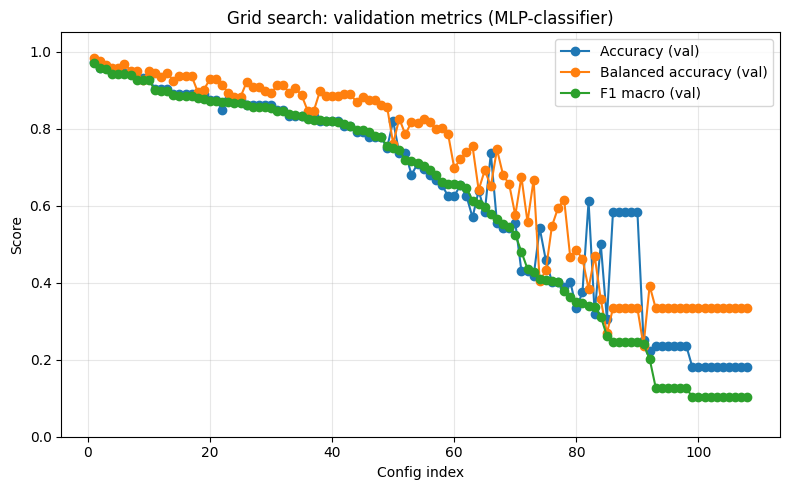

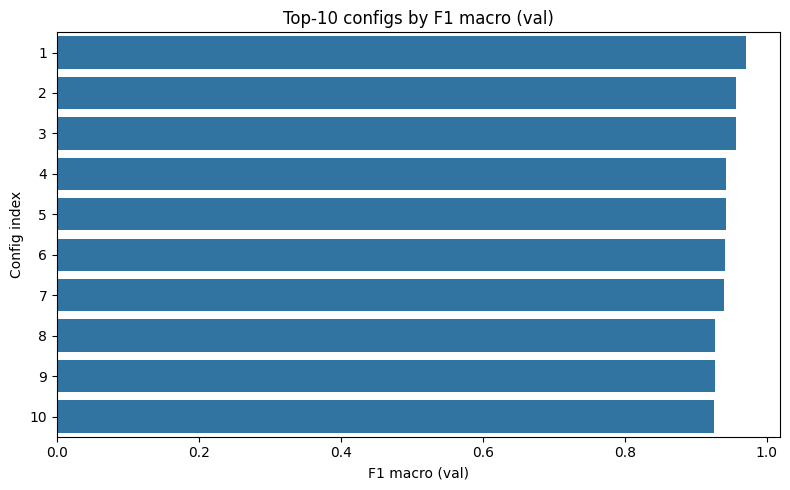

In [54]:
# Визуализация метрик на валидации (классификация)
assert 'grid_results_df' in globals(), 'Сначала выполните ячейку с grid search.'

# Индексы конфигураций
names_val = list(range(1, len(grid_results_df) + 1))

# Списки метрик
acc_val_list = grid_results_df['acc_val'].tolist()
bal_acc_val_list = grid_results_df['bal_acc_val'].tolist()
f1_macro_val_list = grid_results_df['f1_macro_val'].tolist()

# Линейные графики трёх метрик
plt.figure(figsize=(8, 5))
plt.plot(names_val, acc_val_list, 'o-', label='Accuracy (val)')
plt.plot(names_val, bal_acc_val_list, 'o-', label='Balanced accuracy (val)')
plt.plot(names_val, f1_macro_val_list, 'o-', label='F1 macro (val)')
plt.title('Grid search: validation metrics (MLP-classifier)')
plt.xlabel('Config index')
plt.ylabel('Score')
plt.ylim(0.0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Барчарт топ-10 конфигураций по F1 macro
topN = grid_results_df.copy()
topN['config_idx'] = np.arange(1, len(topN) + 1)
topN = topN.sort_values('f1_macro_val', ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(data=topN, x='f1_macro_val', y='config_idx', orient='h', color='#1f77b4')
plt.xlabel('F1 macro (val)')
plt.ylabel('Config index')
plt.title('Top-10 configs by F1 macro (val)')
plt.tight_layout()
plt.show()
